In [12]:
import pandas as pd

## Sampling collisions

In [17]:
model_names = ['gemma-3-1b-pt', 'gemma-3-4b-pt', 'gemma-3-12b-pt', 'gpt2', 'gpt2-medium', 'gpt2-large', 'Llama-3.1-8B', 'Mistral-7B-v0.1', 'Phi-4-mini-instruct', 'TinyStories-1M', 'TinyStories-8M', 'TinyStories-33M']

In [29]:
model_names = ['gemma-3-1b-pt', 'gemma-3-4b-pt', 'gemma-3-12b-pt', 'gpt2', 'gpt2-medium', 'gpt2-large', 'Llama-3.1-8B', 'Mistral-7B-v0.1', 'Phi-4-mini-instruct', 'TinyStories-1M', 'TinyStories-8M', 'TinyStories-33M']

for model in model_names:

    filename_fn = lambda x: f'{x}-layer-stats.csv'
    df = pd.read_csv(f'../data/sampling_collisions/{filename_fn(model)}')

    print(df.head())

   layer       count        mean         std       min          max
0      1  4999950000  388.000867   81.484355  0.690545  1221.549438
1      2  4999950000  454.868565   83.023647  1.488919  1197.440063
2      3  4999950000  522.992854   88.149104  2.125064  1582.803589
3      4  4999950000  636.365883  139.904533  2.682702  1849.554932
4      5  4999950000  756.525868  315.431737  5.326268  6730.736328
   layer       count         mean          std       min           max
0      1  4999950000   755.600975   570.572009  0.581290  10856.806641
1      2  4999950000   787.215231   586.668592  1.633421  11545.596680
2      3  4999950000   885.661262   788.778374  1.971468  17010.734375
3      4  4999950000   948.739379   916.405098  2.184747  19956.787109
4      5  4999950000  1184.181242  1409.029561  4.980736  31204.494141
   layer       count         mean          std       min           max
0      1  4999950000   889.823674   562.720207  0.896930   8438.365234
1      2  4999950000   8

In [33]:
# Boxplots per model (one figure per model), using only per-layer summary stats.
# Adds a red dashed y=0 "collision threshold" line and starts y-axis a bit below 0.
# (Note: log scale cannot show y=0; we auto-disable log when drawing the zero line.)

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
data_dir = "../data/sampling_collisions"  # where the CSVs live
output_dir = "./figs_boxplots"            # where to save figures
os.makedirs(output_dir, exist_ok=True)

model_names = [
    'gemma-3-1b-pt', 'gemma-3-4b-pt', 'gemma-3-12b-pt',
    'gpt2', 'gpt2-medium', 'gpt2-large',
    'Llama-3.1-8B', 'Mistral-7B-v0.1', 'Phi-4-mini-instruct',
    'TinyStories-1M', 'TinyStories-8M', 'TinyStories-33M'
]

# -----------------------
# Helpers
# -----------------------
Z_25 = 0.6744897501960817  # Φ^{-1}(0.75) for normal ≈ 0.67449

def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def stats_row_to_bxp_dict(row):
    """
    Convert a row with (layer, mean, std, min, max) to a dict for matplotlib.bxp.
    Expected row fields: 'layer', 'mean', 'std', 'min', 'max'
    """
    lyr = int(row["layer"])
    mu  = _safe_float(row["mean"])
    sd  = _safe_float(row["std"])
    mn  = _safe_float(row["min"])
    mx  = _safe_float(row["max"])

    # Fallbacks if missing/NaN
    if np.isnan(mu): mu = 0.0
    if np.isnan(sd): sd = 0.0
    if np.isnan(mn): mn = mu
    if np.isnan(mx): mx = mu

    # Ensure min <= max
    if mx < mn:
        mn, mx = mx, mn

    # Approximate quartiles (normal assumption), then clamp to [min, max]
    q1 = mu - Z_25 * sd
    q3 = mu + Z_25 * sd
    med = mu

    q1 = min(max(q1, mn), mx)
    q3 = min(max(q3, mn), mx)
    med = min(max(med, mn), mx)

    # If q1 > q3 (pathological due to clamping), collapse to median
    if q1 > q3:
        q1 = q3 = med = min(max(mu, mn), mx)

    return {
        "label": f"L{lyr}",
        "whislo": mn,   # bottom whisker
        "q1": q1,       # 25th percentile
        "med": med,     # median (here: mean, clamped)
        "q3": q3,       # 75th percentile
        "whishi": mx,   # top whisker
        "fliers": []
    }

# -----------------------
# Main plotting loop
# -----------------------
for model in model_names:
    filename = f"{model}-layer-stats.csv"
    path = os.path.join(data_dir, filename)
    df = pd.read_csv(path)

    # Expect columns: layer, count, mean, std, min, max
    required = {"layer", "mean", "std", "min", "max"}
    missing = required - set(map(str.lower, df.columns))
    if missing:
        # Try case-insensitive rename
        lower_map = {c.lower(): c for c in df.columns}
        df = df.rename(columns={lower_map.get(k, k): k for k in required if k in lower_map})

    # Sort by layer
    if "layer" in df.columns:
        df = df.sort_values("layer")

    # Build bxp stats list
    bxp_stats = [stats_row_to_bxp_dict(row) for _, row in df.iterrows()]

    # Plot
    use_log_y = True  # you can keep this True globally...
    want_zero_line = False  # ...but we must disable log when drawing a zero line

    if want_zero_line and use_log_y:
        # log scale can't include y=0; force linear for this figure
        use_log_y = False
        print(f"[{model}] Disabled log scale to draw y=0 collision threshold.")

    fig, ax = plt.subplots(figsize=(max(8, len(bxp_stats) * 0.35), 5))
    ax.bxp(bxp_stats, showfliers=False, widths=0.6)

    ax.set_title(f"{model} — per-layer boxplots from summary stats")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Value")

    # Improve readability
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.tick_params(axis="x", labelrotation=0)

    # Set scale if still requested and valid
    if use_log_y:
        all_vals = []
        for b in bxp_stats:
            all_vals.extend([b["whislo"], b["q1"], b["med"], b["q3"], b["whishi"]])
        if all(v > 0 for v in all_vals):
            ax.set_yscale("log")

    # ---- Zero reference line + slight padding below zero ----
    if want_zero_line:
        # Draw the line
        ax.axhline(0.0, linestyle="--", linewidth=1.5, color="red", alpha=0.9, zorder=10)
        # Annotate near the right edge, slightly above the line
        ax.annotate(
            "collision threshold",
            xy=(0.995, 0.0), xycoords=("axes fraction", "data"),
            ha="right", va="bottom",
            fontsize=10, color="red",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
        )
        # Expand y-limits to start a bit below zero (e.g., ~3% of the max range)
        ymax = max(b["whishi"] for b in bxp_stats)
        pad = max(1e-6, 0.03 * ymax)  # ensure some visible padding
        ax.set_ylim(-pad, ymax + pad)

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"{model}-layer-boxplot.png")
    plt.savefig(out_path, dpi=200)
    plt.close(fig)

print(f"Saved boxplot figures to: {os.path.abspath(output_dir)}")


Saved boxplot figures to: /media/donato/Extra-storage/Code/other/plots/notebooks/figs_boxplots


## Exhaustive

In [34]:
model_names = ['gemma-3-1b-pt', 'gpt2']

In [36]:
for model in model_names:

    filename_fn = lambda x: f'{x}-sample-stats.csv'
    df = pd.read_csv(f'../data/exhaustive/{filename_fn(model)}')

    print(df.head())

   sample_idx        count          mean          std        min           max
0           0  34359869440   9491.273973  2122.655164  28.347353  46543.382812
1           1  34359869440   9338.912643  1939.911406  27.463047  38455.750000
2           2  34359869440  10061.169184  1784.916624  26.331551  48011.203125
3           3  34359869440  10436.978361  2685.334255  43.648937  52808.609375
4           4  34359869440   9646.630449  2012.337411  29.853027  38111.019531
   sample_idx       count        mean        std       min          max
0           0  1262908153  181.936430  41.492789  3.429164  1129.703613
1           1  1262908153  168.808854  38.830127  4.335365  1112.325928
2           2  1262908153  166.570910  41.829423  3.037109   997.642029
3           3  1262908153  161.068692  34.259261  5.177292   951.377075
4           4  1262908153  151.167611  29.910828  4.431568   973.604980


## Sequence length

In [38]:
model_names = ['gemma-3-1b-pt', 'gpt2']

for model in model_names:

    filename_fn = lambda x: f'{x}-layer-length-stats.csv'
    df = pd.read_csv(f'../data/seq_length_ablation/{filename_fn(model)}')

    print(df.head())

   layer  length     count          mean          std          min  \
0     26      20  49994963  12022.628010  2200.396388  1907.496094   
1     26      40  49994976  12724.423054  2360.091636   436.333496   
2     26      60  49994995  12974.092738  2501.040001  1031.077393   
3     26      80  49994998  13147.599481  2527.923922   398.565430   
4     26     100  49994999  13194.214511  2578.286006  1520.329346   

            max  
0  40160.304688  
1  44681.972656  
2  52858.804688  
3  50035.449219  
4  53408.054688  
   layer  length     count        mean         std       min          max
0     12      20  49994821  284.137408  112.659850  0.000420  1479.251465
1     12      40  49994984  308.696301  120.457262  0.000466  1394.722778
2     12      60  49994994  318.591916  122.864669  0.000746  1580.808838
3     12      80  49994995  328.647104  129.396979  4.878380  1597.845215
4     12     100  49994996  333.699054  131.351975  5.765115  1414.837280


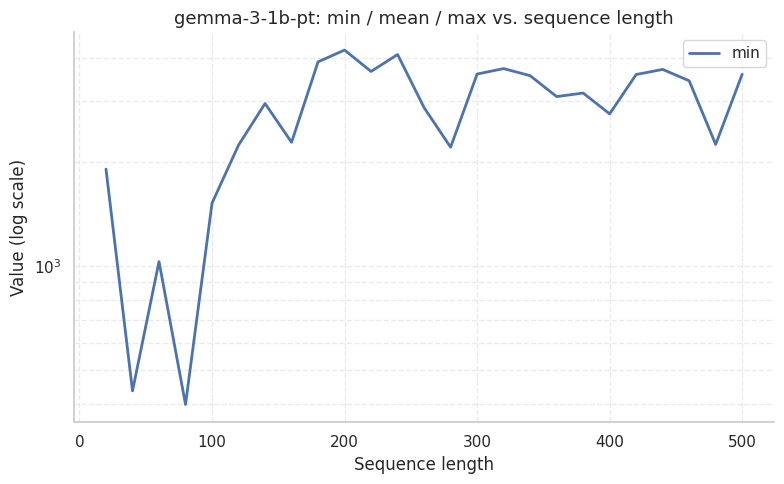

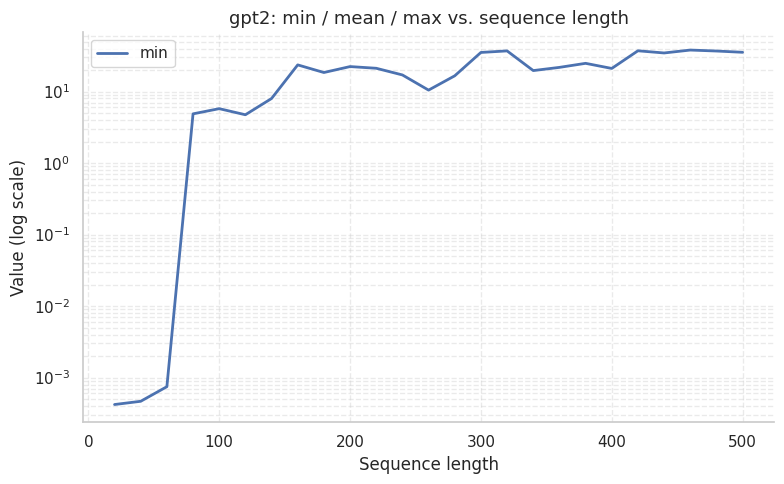

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model_names = ['gemma-3-1b-pt', 'gpt2']

for model in model_names:
    filename_fn = lambda x: f'{x}-layer-length-stats.csv'
    df = pd.read_csv(f'../data/seq_length_ablation/{filename_fn(model)}')

    # Ensure numeric and collapse any duplicate 'length' rows (e.g., multiple layers)
    cols = ['length', 'min', 'mean', 'max']
    # Some CSVs might have capitalization differences; normalize:
    df = df.rename(columns={c: c.lower() for c in df.columns})
    needed = ['length', 'min', 'mean', 'max']
    if not set(needed).issubset(df.columns):
        missing = set(needed) - set(df.columns)
        raise ValueError(f"Missing columns in {model}: {missing}")

    # Make sure they're numeric
    for c in needed:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Aggregate in case multiple rows per length exist (e.g., different layers)
    agg = (
        df.groupby('length', as_index=False)[['min', 'mean', 'max']]
          .mean()
          .sort_values('length')
    )

    x = agg['length'].values
    y_min = agg['min'].values
    y_mean = agg['mean'].values
    y_max = agg['max'].values

    plt.figure(figsize=(8, 5))
    plt.plot(x, y_min, label='min', linewidth=2)
    # plt.plot(x, y_mean, label='mean', linewidth=2)
    # plt.plot(x, y_max, label='max', linewidth=2)

    plt.yscale('log')
    plt.xlabel('Sequence length', fontsize=12)
    plt.ylabel('Value (log scale)', fontsize=12)
    plt.title(f'{model}: min / mean / max vs. sequence length', fontsize=13)
    plt.grid(True, which='both', linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    # Optional: save per model
    # outdir = "./figs_seq_length"
    # os.makedirs(outdir, exist_ok=True)
    # plt.savefig(os.path.join(outdir, f"{model}_min_mean_max_vs_length.png"), dpi=200)

    plt.show()
